In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet18  # Using a basic, small ResNet variant
from torch import nn

# Transformation for CIFAR-10 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard normalization for CIFAR-10
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Modify ResNet for CIFAR-10 (assume using resnet18)
model = resnet18()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer to accept 32x32 input
model.maxpool = nn.Identity()  # Remove maxpool to keep dimensionality
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting final fully connected layer for 10 classes

# Assuming use of a GPU if available
device = torch.device("mps")
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [2]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

In [ ]:
import torch.optim as optim
from torch import nn

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Define number of epochs
num_epochs = 1

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss: {running_loss / 200:.4f}')
            running_loss = 0.0

print('Finished Training')
torch.save(model.state_dict(), "state")

# Evaluate the model
evaluate_model(model, testloader)


In [3]:
model = resnet18()  # Not using pre-trained weights
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer to accept 32x32 input
model.maxpool = nn.Identity()  # Remove maxpool to keep dimensionality
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting final fully connected layer for 10 classes
model.to(device)
model.load_state_dict(torch.load("state"))


<All keys matched successfully>

In [4]:
evaluate_model(model, testloader)


Accuracy of the model on the test images: 73.57%


73.57

In [7]:
%load_ext autoreload
%autoreload now
import copy
import pruning_funcs
import numpy as np

percent_prune = []
percent_prune_with_bernoulli = []

for percent in range(1,6):
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune(pruned_model, device, percent=percent)
    percent_prune.append(evaluate_model(pruned_model, testloader))

    ppwb_runs = []
    for i in range(5):
        pruned_model_2 = copy.deepcopy(model)
        pruning_funcs.percent_prune_with_bernoulli(pruned_model_2, device, percent=(2*percent), p_success=0.5)
        ppwb_runs.append(evaluate_model(pruned_model_2, testloader))

    percent_prune_with_bernoulli.append(np.mean(ppwb_runs))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Accuracy of the model on the test images: 72.63%
Accuracy of the model on the test images: 71.46%
Accuracy of the model on the test images: 71.89%
Accuracy of the model on the test images: 71.21%
Accuracy of the model on the test images: 70.95%
Accuracy of the model on the test images: 70.65%
Accuracy of the model on the test images: 67.29%
Accuracy of the model on the test images: 68.6%
Accuracy of the model on the test images: 69.26%
Accuracy of the model on the test images: 67.67%
Accuracy of the model on the test images: 68.12%
Accuracy of the model on the test images: 68.9%
Accuracy of the model on the test images: 64.42%
Accuracy of the model on the test images: 69.29%
Accuracy of the model on the test images: 64.34%
Accuracy of the model on the test images: 67.4%
Accuracy of the model on the test images: 65.13%
Accuracy of the model on the test images: 68.24%
Accuracy of the model on the test

/var/folders/r0/g630ksd54rzd5q60gtr3_k0w0000gn/T/ipykernel_82968/801749158.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


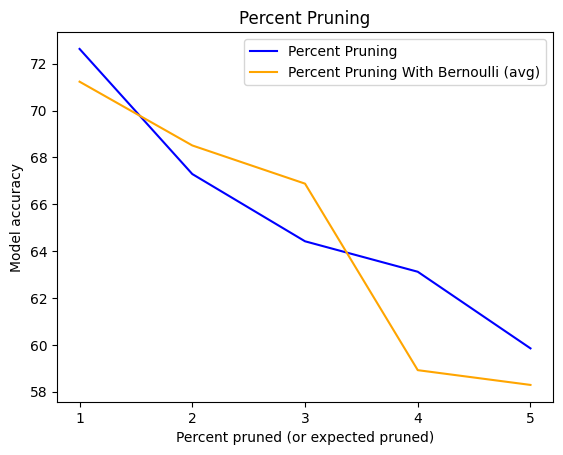

In [12]:
import matplotlib.pyplot as plt
import numpy as np

percents = np.arange(1,6,1)

fig, ax = plt.subplots()
ax.set_title("Percent Pruning")
line1, = ax.plot(percents, percent_prune, color='blue')
line2, = ax.plot(percents, percent_prune_with_bernoulli, color='orange')
line1.set_label("Percent Pruning")
line2.set_label("Percent Pruning With Bernoulli (avg)")
ax.legend()
ax.set_xlabel("Percent pruned (or expected pruned)")
ax.set_ylabel("Model accuracy")
ax.set_xticks(percents)
fig.show()


/var/folders/r0/g630ksd54rzd5q60gtr3_k0w0000gn/T/ipykernel_82968/3015095372.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


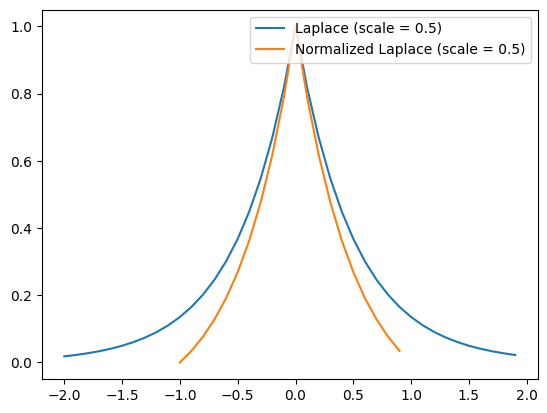

In [26]:
# Graph Laplace Distribution
import numpy as np
import matplotlib.pyplot as plt

loc=0
scale=0.5

x = np.arange(-2, 2, 0.1)

pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
new_min = np.exp(-abs(1.-loc)/scale)/(2.*scale)
x2 = np.arange(-1, 1, 0.1)
modified_pdf = (np.exp(-abs(x2-loc)/scale)/(2.*scale) - np.exp(-abs(1.-loc)/scale)/(2.*scale)) / (1-new_min)

fig, ax = plt.subplots()
line1, = ax.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax.legend()
fig.show()


In [17]:
%load_ext autoreload
%autoreload now
import pruning_funcs

pruned_model = copy.deepcopy(model)
pruning_funcs.laplace_prune(pruned_model, device)
evaluate_model(pruned_model, testloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Accuracy of the model on the test images: 10.0%


10.0